In [1]:
import sys
sys.path.insert(0, "../fairseq")
sys.path.insert(0, "../")
sys.path.insert(0, "~/utility/imputer-pytorch")
# %load_ext autoreload
# %autoreload 2

In [2]:
# https://github.com/pytorch/fairseq/blob/master/fairseq_cli/generate.py

In [3]:
from fairseq import (
    checkpoint_utils,
    options,
    quantization_utils,
    tasks,
    utils,
)
from torchinfo import summary
import logging
import os
import matplotlib.pyplot as plt
import torch
from torch_imputer import best_alignment

import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='NotoSansSC-Regular.otf')

In [4]:
checkpoint="../expcwmt/checkpoints/sinkhorn_delay3/checkpoint_best.pt"
inference_config_yaml="../expcwmt/infer_mt.yaml"
user_dir="/home/george/Projects/sinkhorn-simultrans/simultaneous_translation"
data_dir="/media/george/Data/cwmt/zh-en/data-bin"
use_cuda = True
# max_tokens = 100
batch_size = 20

states = checkpoint_utils.load_checkpoint_to_cpu(
    path=checkpoint, arg_overrides=None, load_on_all_ranks=False)
cfg = states["cfg"]
cfg.task.inference_config_yaml = inference_config_yaml
cfg.common.user_dir = user_dir
cfg.task.data = data_dir
# cfg.dataset.max_tokens_valid = max_tokens
cfg.dataset.batch_size = batch_size

In [5]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=os.environ.get("LOGLEVEL", "INFO").upper(),
    stream=sys.stdout,
)
logger = logging.getLogger("fairseq_cli.train")

In [6]:
utils.import_user_module(cfg.common)

# Setup task, e.g., translation, language modeling, etc.
task = tasks.setup_task(cfg.task)
# Build model and criterion
model = task.build_model(cfg.model)
criterion = task.build_criterion(cfg.criterion)
logger.info(summary(model))
logger.info("task: {}".format(task.__class__.__name__))
logger.info("model: {}".format(model.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))

2021-08-20 22:40:32 | INFO | fairseq.tasks.translation | [en] dictionary: 32001 types
2021-08-20 22:40:32 | INFO | fairseq.tasks.translation | [zh] dictionary: 32001 types
2021-08-20 22:40:32 | INFO | simultaneous_translation.tasks.inference_config | Cannot find ../expcwmt/infer_mt.yaml
2021-08-20 22:40:33 | INFO | simultaneous_translation.criterion.label_smoothed_ctc_criterion | Using ctc loss for decoder!
2021-08-20 22:40:33 | INFO | fairseq_cli.train | ================================================================================
Layer (type:depth-idx)                                  Param #
SinkhornEncoderModel                                    --
├─ASNAugmentedEncoder: 1-1                              --
│    └─CausalTransformerEncoder: 2-1                    --
│    │    └─FairseqDropout: 3-1                         --
│    │    └─Embedding: 3-2                              16,384,512
│    │    └─SinusoidalPositionalEmbedding: 3-3          --
│    │    └─ModuleList: 3-4      

In [7]:
logger.info("loading model(s) from {}".format(cfg.common_eval.path))
model = task.build_model(cfg.model)
model.load_state_dict(
    states["model"], strict=True, model_cfg=cfg.model
)

# Optimize ensemble for generation
use_fp16 = False
if use_cuda:
    if torch.cuda.get_device_capability(0)[0] >= 7:
        model.half()
        use_fp16 = True
    model.cuda()
model.prepare_for_inference_(cfg)

2021-08-20 22:40:33 | INFO | fairseq_cli.train | loading model(s) from None


In [8]:
task.load_dataset(cfg.dataset.gen_subset, task_cfg=cfg.task)

2021-08-20 22:40:37 | INFO | fairseq.data.data_utils | loaded 1,003 examples from: /media/george/Data/cwmt/zh-en/data-bin/test.zh-en.en
2021-08-20 22:40:37 | INFO | fairseq.data.data_utils | loaded 1,003 examples from: /media/george/Data/cwmt/zh-en/data-bin/test.zh-en.zh
2021-08-20 22:40:37 | INFO | fairseq.tasks.translation | /media/george/Data/cwmt/zh-en/data-bin test en-zh 1003 examples


In [30]:
# Load dataset 
itr = task.get_batch_iterator(
    dataset=task.dataset(cfg.dataset.gen_subset),
    max_tokens=cfg.dataset.max_tokens,
    max_sentences=cfg.dataset.batch_size,
    max_positions=utils.resolve_max_positions(
        task.max_positions(), model.max_positions() #*[m.max_positions() for m in models]
    ),
    ignore_invalid_inputs=cfg.dataset.skip_invalid_size_inputs_valid_test,
    required_batch_size_multiple=cfg.dataset.required_batch_size_multiple,
    seed=cfg.common.seed,
    num_shards=cfg.distributed_training.distributed_world_size,
    shard_id=cfg.distributed_training.distributed_rank,
    num_workers=cfg.dataset.num_workers,
    data_buffer_size=cfg.dataset.data_buffer_size,
).next_epoch_itr(shuffle=False)

generator = task.build_generator(
    [model], cfg.generation, extra_gen_cls_kwargs=None
)

# Handle tokenization and BPE
def decode(
    tensor,
    dictionary,
    escape_unk=False,
    unk_string=None,
    include_eos=False,
    separator=None,
):
    def token_string(i):
        if i == dictionary.unk():
            if unk_string is not None:
                return unk_string
            else:
                return dictionary.unk_string(escape_unk)
        elif i == dictionary.bos():
            return "$\phi$"
        else:
            return dictionary[i]

    sent = [token_string(i) for i in tensor]
    return sent if separator is None else separator.join(sent)

In [94]:
def apply_half(t):
    if t.dtype is torch.float32:
        return t.half()
    return t

skips = 0
for i,sample in enumerate(itr):
    if use_cuda:
        sample = utils.move_to_cuda(sample) 
        if use_fp16:
            sample = utils.apply_to_sample(apply_half, sample)
    if "net_input" not in sample or i<skips:
        continue

    break

src_tokens = sample["net_input"]["src_tokens"]
src_lengths = sample["net_input"]["src_lengths"]
prev_output_tokens = sample["net_input"]["prev_output_tokens"]
target = sample["target"]
logits, extra = model.forward(src_tokens, src_lengths, prev_output_tokens=prev_output_tokens, return_all_hiddens=True)
pred_argmax = logits.argmax(-1)
[decode(t, task.src_dict) for t in src_tokens][:10]

[['▁the',
  '▁us',
  '▁survey',
  '▁reveals',
  '▁unemployment',
  "'",
  's',
  '▁impacts',
  '▁on',
  '▁health',
  '</s>'],
 ['▁if',
  '▁you',
  '▁have',
  '▁interest',
  ',',
  '▁you',
  '▁will',
  '▁not',
  '▁feel',
  '▁difficult',
  '</s>'],
 ['▁the',
  '▁management',
  '▁over',
  '▁school',
  "'",
  's',
  '▁surroundings',
  '▁should',
  '▁be',
  '▁intensified',
  '</s>'],
 ['▁he',
  '▁prepares',
  '▁to',
  '▁introduce',
  '▁and',
  '▁spread',
  '▁the',
  '▁fast',
  'ing',
  '▁practice',
  '</s>'],
 ['▁cai', '▁wei', ':', '▁yes', ',', '▁it', "'", 's', '▁true', '.', '</s>'],
 ['▁before',
  '▁the',
  '▁love',
  ',',
  '▁age',
  '▁is',
  '▁not',
  '▁a',
  '▁problem',
  '.',
  '</s>'],
 ['▁exotic',
  '▁happy',
  '▁face',
  '▁spiders',
  '▁found',
  '▁in',
  '▁the',
  '▁jungle',
  '▁of',
  '▁hawaii',
  '</s>'],
 ['▁was',
  '▁it',
  '▁possible',
  '▁that',
  '▁he',
  '▁was',
  '▁not',
  '▁fine',
  '?',
  '</s>',
  '<pad>'],
 ['▁"',
  'force',
  '"',
  '▁villagers',
  '▁to',
  '▁build',


In [95]:
if use_cuda:
    net_output = (logits, extra)
    lprobs = model.get_normalized_probs(
        net_output, log_probs=True
    )
    bsz = target.size(0)
    max_src = lprobs.size(1)
    lprobs = lprobs.transpose(1, 0).contiguous()

    # get subsampling padding mask & lengths
    if net_output[1]["padding_mask"] is not None:
        non_padding_mask = ~net_output[1]["padding_mask"]
        input_lengths = non_padding_mask.long().sum(-1)
    else:
        input_lengths = lprobs.new_ones(
            (bsz, max_src), dtype=torch.long).sum(-1)

    pad_mask = (target != task.tgt_dict.pad()) & (
       target != task.tgt_dict.eos()
    )
    #pad_mask = (target != task.tgt_dict.pad())
    targets_flat = target.masked_select(pad_mask)
    target_lengths = pad_mask.long().sum(-1)

    forced_states = best_alignment(
        lprobs, target, input_lengths, target_lengths, blank=0, zero_infinity=False
    )
    pred_forced = [
        [0 if state % 2 == 0 else sent[state // 2] for state in states]
        for states, sent in zip(forced_states, target)
    ]
    for x in pred_forced:
        if len(x) < max_src:
            x.extend([task.tgt_dict.pad()]*(max_src-len(x)))
else:
    pred_forced = pred_argmax

In [96]:
from typing import Optional, Callable
# from matplotlib import font_manager

# fontP = font_manager.FontProperties()
# fontP.set_family('SimHei')
# fontP.set_size(14)

def plot_align(
    aln,
    titles: Optional[list]=None,
    x_tokens: Optional[list]=None,
    y_tokens: Optional[list]=None,
    norm_fn: Optional[Callable]=lambda x:x,
    columns: Optional[int]=1,
    tick_size: Optional[int]=10,
    fig_size: Optional[tuple]=(12,8),
    save: Optional[str]=None,
    cmap=plt.cm.viridis #plt.cm.Blues,
):
    """Function to plot the alignment with tokens
    """
    
    n_graphs = len(aln)
    rows = 1+(n_graphs // columns)
    ylen, xlen = aln[0].shape
    
    if titles is None:
        titles = [f"example {i}" for i in range(n_graphs)]
    if x_tokens is None:
        x_tokens = [range(xlen)]*n_graphs
    if y_tokens is None:
        y_tokens = [range(ylen)]*n_graphs    
    
    fig = plt.figure(figsize=(fig_size[0]*columns,fig_size[1]*rows), dpi=100) 
    for i,a in enumerate(aln):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(norm_fn(a), cmap=cmap)
        ax.set_title(titles[i%len(titles)]) # title
        for tick in ax.get_xticklabels(): # diagonal xtick
            tick.set_rotation(45)
            tick.set_fontproperties(fprop)        
        for tick in ax.get_yticklabels():
            tick.set_fontproperties(fprop)
        ax.set_xticks(range(xlen)) 
        ax.set_xticklabels(x_tokens[i%len(x_tokens)], fontsize=tick_size)
        ax.set_yticks(range(ylen)) 
        ax.set_yticklabels(y_tokens[i%len(y_tokens)], fontsize=tick_size)
        
     
    if save is not None:
        fig.savefig(save)

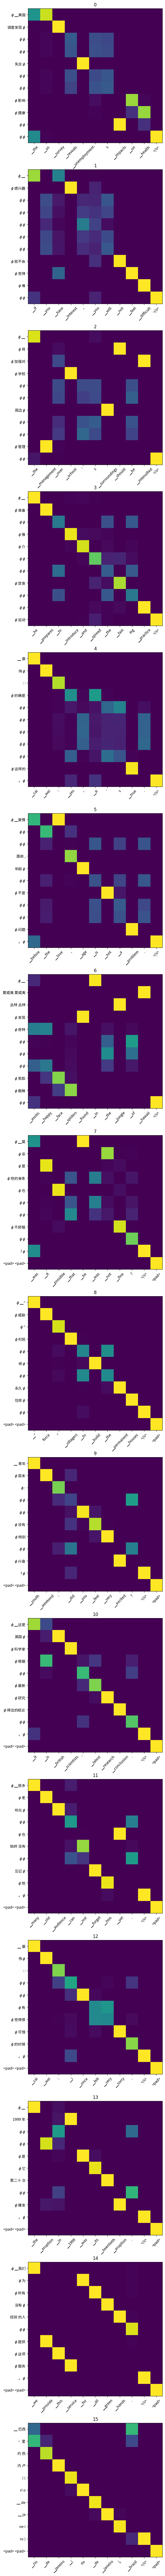

In [97]:
N = 1000

x_tokens = [decode(t, task.src_dict) for t in src_tokens[:N]]
y_tokens = [decode(t, task.tgt_dict) for t in pred_forced[:N]]
y_tokens = [
    [l+" "+r for l, r in zip(sent[::2], sent[1::2])]
    for sent in y_tokens]

attn_weights = extra["attn"][0].data.float().cpu()
log_alpha = extra["log_alpha"][0].data.float().cpu()
b, n = attn_weights.shape[:2]
plot_align(
    attn_weights[:N],
    x_tokens=x_tokens,
    y_tokens=y_tokens,
    titles = list(range(len(x_tokens))),
)

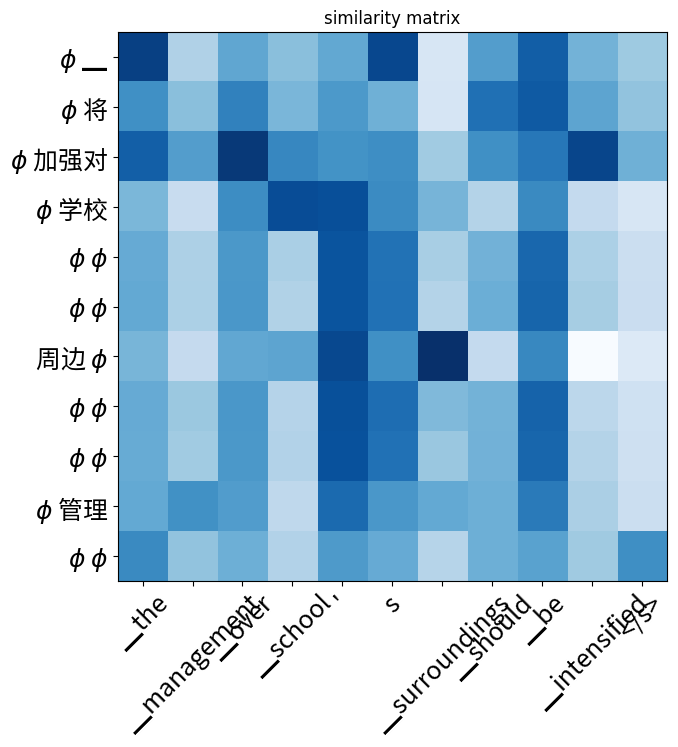

In [101]:
eid = 2

x_tokens = [decode(t, task.src_dict) for t in src_tokens[eid:eid+1]]
y_tokens = [decode(t, task.tgt_dict) for t in pred_forced[eid:eid+1]]
y_tokens = [
    [l+" "+r for l, r in zip(sent[::2], sent[1::2])]
    for sent in y_tokens]

log_alpha = extra["log_alpha"][0].data.float().cpu()
b, n = attn_weights.shape[:2]
plot_align(
    log_alpha[eid:eid+1],
    x_tokens=x_tokens,
    y_tokens=y_tokens,
    titles = ["similarity matrix"],
    cmap=plt.cm.Blues,
    tick_size=18
)

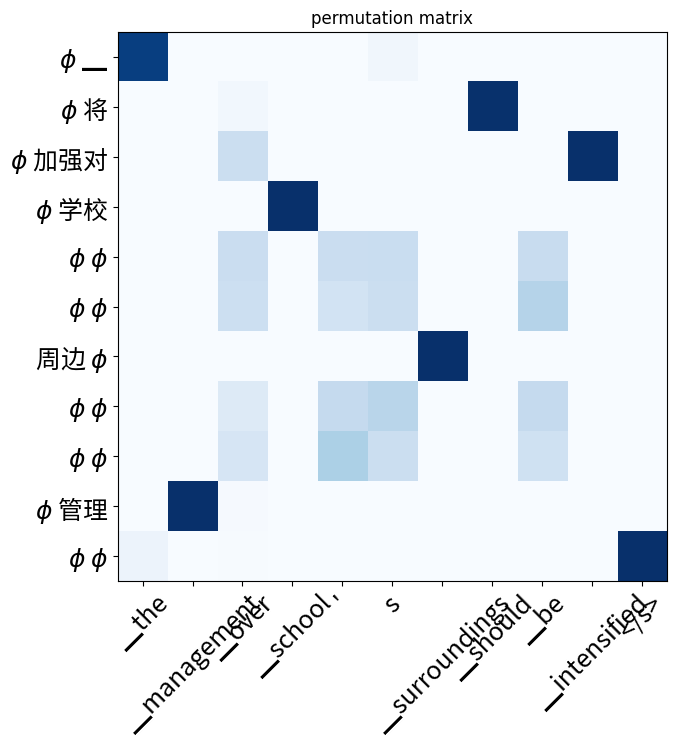

In [102]:
from simultaneous_translation.modules.sinkhorn_attention import (
    gumbel_sinkhorn
)

attn_weights = gumbel_sinkhorn(
    log_alpha,
    tau=0.25,
    n_iter=16,
    noise_factor=0.
)
plot_align(
    attn_weights[eid:eid+1],
    x_tokens=x_tokens,
    y_tokens=y_tokens,
    titles = ["permutation matrix"],
    cmap=plt.cm.Blues,
    tick_size=18
)

In [103]:
causal_logits, _ = model.forward_causal(src_tokens, src_lengths)
causal_pred_argmax = causal_logits.argmax(-1)
print(decode(causal_pred_argmax[eid:eid+1][0], task.tgt_dict))

['$\\phi$', '▁', '$\\phi$', '管理', '$\\phi$', '对', '$\\phi$', '学校', '$\\phi$', '$\\phi$', '$\\phi$', '$\\phi$', '环境', '环境', '$\\phi$', '应', '$\\phi$', '$\\phi$', '$\\phi$', '加强', '$\\phi$', '</s>']
